# Course Project 
<p> <br>
Author  - Vazgen Tadevosyan <br></p>

For the course project, we will investigate the problem of predicting readmission of hospital patients. Readmission of patients following discharge from hospital places an enormous and very expensive burden on the US healthcare system (estimated at $40B in 2011)<br>
Besides administration of hospitals might also be concerned what factors make cause readmission.
Keeping that in mind I will try to present feature importances as well.

# Content of the project:
* [Data reading and initial preprocessing](#Reading-data)
    1. The dataset may have duplicates, missing values and other data quality issues that may need to be addressed.  
    2. The class variable may need to be derived in some manner.
    3.  Understanding the different attributes distribution, and correlation with the class
* [Data cleaning](#Data-Cleaning)
    1. Making data clean for further analysis
    2. Some features may need to be transformed to improve performance



In [1]:
# 
import re

#for not showing warnings
import warnings
warnings.filterwarnings('ignore')


#data manipulation and visualization libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#libraries for modelling and evaluation
from scipy import stats
from sklearn.metrics import  roc_curve
from sklearn.tree import export_graphviz
from sklearn.metrics import roc_auc_score
from  sklearn.metrics import recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import  RandomForestClassifier
from sklearn.model_selection import  cross_val_score
from sklearn.linear_model import  LogisticRegression
from statsmodels.discrete.discrete_model import Logit 
from sklearn.ensemble import  GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report
#in case of error run <<!pip install>> and run the code again

## Reading data

Exploring and sanitizing the data

In [140]:
for_mapping = pd.read_csv("IDs_mapping.csv")
train_data = pd.read_csv("diabetic_data_train.csv")
test_data = pd.read_csv('diabetic_data_test.csv')

Mapping data is not clean, several columns are merged into one.We need extract that for further use

In [141]:
for_mapping['admission_type_id'].unique()

array(['1', '2', '3', '4', '5', '6', '7', '8', nan,
       'discharge_disposition_id', '9', '10', '11', '12', '13', '14',
       '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25',
       '26', '30', '27', '28', '29', 'admission_source_id'], dtype=object)

In order to switch addmission type values I used IDs_mapping dataset to map names by admission_type Id

In [142]:
admission_type_id = for_mapping[:8]
discharge_disposition_id = for_mapping[9:40]
print('discharge_disposition should be column')
print("\n")
discharge_disposition_id.head()

discharge_disposition should be column




,admission_type_id,description
9,discharge_disposition_id,description
10,1,Discharged to home
11,2,Discharged/transferred to another short term h...
12,3,Discharged/transferred to SNF
13,4,Discharged/transferred to ICF


In [143]:
print('problem solved')
discharge_disposition_id = discharge_disposition_id.rename(columns = discharge_disposition_id.iloc[0]).drop(discharge_disposition_id.index[0])
discharge_disposition_id.head()

problem solved


,discharge_disposition_id,description
10,1,Discharged to home
11,2,Discharged/transferred to another short term h...
12,3,Discharged/transferred to SNF
13,4,Discharged/transferred to ICF
14,5,Discharged/transferred to another type of inpa...


In [144]:
admission_source_id = for_mapping[41:]
print('admission_source_id should be column')
print("\n")
admission_source_id.head()

admission_source_id should be column




,admission_type_id,description
41,admission_source_id,description
42,1,Physician Referral
43,2,Clinic Referral
44,3,HMO Referral
45,4,Transfer from a hospital


In [145]:
print('problem solved')
admission_source_id = admission_source_id.rename(columns = admission_source_id.iloc[0]).drop(admission_source_id.index[0])
admission_source_id.head()

problem solved


,admission_source_id,description
42,1,Physician Referral
43,2,Clinic Referral
44,3,HMO Referral
45,4,Transfer from a hospital
46,5,Transfer from a Skilled Nursing Facility (SNF)


In [146]:

def make_dict(dataframe):
    """ We cannot have space and \\ lines in our variable becuase it will raise an error later,let's eschew
    it now"""
    keys = dataframe.iloc[:,0].tolist()
    values = [re.sub("[/,\s]", '_', i.strip()) for i in dataframe.iloc[:,1].astype(str).tolist()]
    return dict(zip(keys,values))


type_id = make_dict(admission_type_id)
source_id = make_dict(admission_source_id)
discharge_id = make_dict(discharge_disposition_id)

In [147]:
#mapping descriptions
train_data['admission_type_id'] = train_data['admission_type_id'].astype('str').map(type_id)
test_data['admission_type_id']  = test_data['admission_type_id'].astype('str').map(type_id)

train_data['discharge_disposition_id'] = train_data['discharge_disposition_id'].astype('str').map(discharge_id)
test_data['discharge_disposition_id'] = train_data['discharge_disposition_id'].astype('str').map(discharge_id)

train_data['admission_source_id'] =train_data['admission_source_id'].astype('str').map(source_id)
test_data['admission_source_id'] =train_data['admission_source_id'].astype('str').map(source_id)

#renaming columns.
train_data.rename({'admission_type_id':'admission_type','discharge_disposition_id':'dischargeDisposition',
                  'admission_source_id':'admission_source'},inplace=True,axis=1)
test_data.rename({'admission_type_id':'admission_type','discharge_disposition_id':'dischargeDisposition',
                  'admission_source_id':'admission_source'},inplace=True,axis=1)


In [148]:
#makin nan in appropriate format as they were in string format
train_data['admission_type'][train_data['admission_type']=='nan']=np.nan
train_data['dischargeDisposition'][train_data['dischargeDisposition']=='nan']=np.nan
train_data['admission_source'][train_data['admission_source']=='nan']=np.nan


test_data['admission_type'][train_data['admission_type']=='nan']=np.nan
test_data['dischargeDisposition'][train_data['dischargeDisposition']=='nan']=np.nan
test_data['admission_source'][train_data['admission_source']=='nan']=np.nan

Once initial data merging is processed let's start to explore and sanite the training data.
Note: if something in training data is changed the same should be applied on test data.

# 1.Exploring and sanitizing the training data
- Checking Dataset size
- Finding columns with NaN values
- Checking whether data has duplicates
- Analyzing Distribution of features

In [149]:
"The training data has {0} rows and {1} columns".format(*train_data.shape)

'The training data has 76324 rows and 51 columns'

The code below shows the columns having missing values

In [150]:
columns_with_na = train_data.columns[train_data[(train_data=='?') | (train_data=='None') | (train_data=='Unknown/Invalid')].any()]
columns_with_na

Index(['race', 'gender', 'weight', 'payer_code', 'medical_specialty', 'diag_1',
       'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult'],
      dtype='object')

We can't use following columns patient_nbr,encounter_id, 'Unnamed: 0', I'll drop them later with other redundant ones if any.

In [151]:
columns_should_be_dropped = ['patient_nbr','encounter_id', 'Unnamed: 0']
def find_columns_with_many_nas(data):
    """If in a given column missing values are more than 30%
    it should be treated as redundant"""
    global columns_should_be_dropped
    columns_should_be_dropped.extend([col for col in data.columns if len(data[(data[col]=='?') | (data[col]=='None')])/len(data) >= 0.3])   

In [152]:
find_columns_with_many_nas(train_data)

Here are the columns that should be dropped as they have more than 30% missing values,

In [153]:
columns_should_be_dropped

['patient_nbr',
 'encounter_id',
 'Unnamed: 0',
 'weight',
 'payer_code',
 'medical_specialty',
 'max_glu_serum',
 'A1Cresult']

Let's see what other columns are remaining with missing values

In [154]:
list(set(columns_with_na)-set(columns_should_be_dropped))

['gender', 'diag_2', 'diag_1', 'diag_3', 'race']

Primary, secondary, final diagnosis have missing values. I'll address race column later

In [155]:
train_data[(train_data['diag_1']=='?') | (train_data['diag_1']=='None')].shape[0]
#number of missing values in diag1

20

In [156]:
train_data[(train_data['diag_2']=='?') | (train_data['diag_2']=='None')].shape[0]
#number of missing values in diag2

276

In [157]:
train_data[(train_data['diag_3']=='?') | (train_data['diag_3']=='None')].shape[0]
#number of missing values in diag3

1081



<div class="alert alert-block alert-info">
<b>Tip:</b>So we have here a little issue with columns diagnosis, we have too many unique values, note this variables is indeed categorical and it has too many unique values however from the this <a href='https://downloads.hindawi.com/journals/bmri/2014/781670.pdf'>link</a> I find out that we must represent them with these categories as it will be very computationally expensive for classifications to use them in a way they are now.</div>


<br><br>Primary diagnosis<br><br>
<div class="alert alert-block alert-warning">
<b>Variable meanings:</b><br> A disease of the circulatory system (icd9: 390–459, 785)<br>X
Diabetes (icd9: 250.xx)<br>
A disease of the respiratory system (icd9: 460–519, 786)<br>
Diseases of the digestive system (icd9: 520–579, 787)<br> 
Injury and poisoning (icd9: 800–999)<br>
Diseases of the musculoskeletal system and connective tissue (icd9: 710–739)<br> 
Diseases of the genitourinary system (icd9: 580–629, 788)<br> 
Neoplasms (icd9: 140–239)<br>
Other
</div>





For that purpose we need to make them numeric values, it will facilitate the further mapping process,
but let's first create mapping function

In [158]:
circulatory_desease = [i for i in list(range(390,460))+[785]]
respiratory_desease = [i for i in list(range(460,520))+[786]]
digestive_desease = [i for i in list(range(520,580))+[787]]
genitourinary_desease = [i for i in list(range(580,630))+[788]]
diabete = [250]
poisoning_Injury = list(range(800,1000))
musculoskeletal_connective_tissue = list(range(710,740))
Neoplasms = list(range(140,249))

In [159]:
diag_mapping = {"circulatory_desease":circulatory_desease, 'respiratory_desease':respiratory_desease,
               'digestive_desease':digestive_desease, 'genitourinary_desease':genitourinary_desease,
               'diabete':diabete, 'poisoning_Injury':poisoning_Injury, 'musculoskeletal_connective_tissue':musculoskeletal_connective_tissue,
               'Neoplasms':Neoplasms}

In [160]:
def mapp_diagnosis(series:pd.Series):
    """This function first make column as numeric.
    Then it maps values to categories,
    if it doesn't find value, it assigns 'other' to it and
    if the value is missing it remains NaN"""
    
    def make_numeric(series):
        """Making column numeric at the same convert ? as Na, we will need this in the future"""
        return pd.to_numeric(series.copy(deep=True), errors='coerce')
    
    new =  make_numeric(series)
    for index,num in enumerate(new):
        if not pd.isna(num):
            for key,value in diag_mapping.items():
                if num in value:
                    new[index]=key
                    break
            else:
                new[index]='other'
    return new

In [161]:
train_data[['diag_1','diag_2','diag_3']] = train_data[['diag_1','diag_2','diag_3']].apply(mapp_diagnosis)
test_data[['diag_1','diag_2','diag_3']] = test_data[['diag_1','diag_2','diag_3']].apply(mapp_diagnosis)

<div class="alert alert-block alert-danger">
<b>Note:</b> Diagnosis variables might be dependent each other, but we can't calculate correlation
</div>

<div class="alert alert-block alert-success">
<b>Solution:</b> For this type of problem we are going to do Mixed Proximity Measure
</div>


Let's define function for nominal variables at.I'll use for it simple match $$d(i,j)=\frac{p-m}{p}$$<br>
Where p is number of nominal variables and p is the number of matches, if the value is 0 they are identical,close each other<br>and contrary as close it is to 1 as dissimilar they are

In [162]:
def simple_match(data,col1,col2):
    """calculates simple match, where p is number of nominal attributes
    m is number of matches"""
    m = (data.dropna()[col1]==data.dropna()[col2]).sum() # we need to drop na otherwise series sizes will be different
    p = len(data.dropna())##dropping NAs are necessary otherwise we can't compare them 
    return (p-m)/p

In [163]:
score1 = simple_match(train_data,'diag_1','diag_2') #dissimality score for diag1 and diag2
score2 = simple_match(train_data,'diag_1','diag_3')#dissimality score for diag1 and diag3
score3 = simple_match(train_data,'diag_2','diag_3')#dissimality score for diag2 and diag3

print("Dissimilarity scores for diag1 and diag2 is {:.3}, for diag1 and diag3 is {:.3} \
      \n and columns diag2 and diag 3 is {:.3}".format(*[score1,score2,score3]))

Dissimilarity scores for diag1 and diag2 is 0.641, for diag1 and diag3 is 0.707       
 and columns diag2 and diag 3 is 0.706


In [164]:
train_data[['diag_1','diag_2','diag_3']].apply(lambda x:pd.isna(x).sum())
#number of missing values

diag_1    1238
diag_2    2196
diag_3    4815
dtype: int64

It is not the result that I expected however I'll keep only primary diagnosis as in the [artice](https://downloads.hindawi.com/journals/bmri/2014/781670.pdf) they kept only this variable, I guess the reason is
diag1 has the least number of missing values compared to the other diagnosis columns

Checking whether there readmitted observations with missing values in primary diagnosis.

In [165]:
train_data.readmitted = train_data.readmitted.apply(lambda x:1 if x=='<30' else 0)
test_data.readmitted = test_data.readmitted.apply(lambda x:1 if x=='<30' else 0)

In [166]:
train_data.readmitted = train_data.readmitted.astype('category')
test_data.readmitted = test_data.readmitted.astype('category')

<div class="alert alert-block alert-warning">
<b>Missing_values:</b> 
As we have missing values this variable seems important feature I'll use KNN to fill them later,
</div>


motivated by [this article](https://machinelearningmastery.com/knn-imputation-for-missing-values-in-machine-learning/)

In [167]:
columns_should_be_dropped.extend(['diag_2','diag_3'])

In [168]:
train_data[['max_glu_serum','A1Cresult']] = train_data[['max_glu_serum','A1Cresult']].replace("None",np.nan)
test_data[['max_glu_serum','A1Cresult']] = test_data[['max_glu_serum','A1Cresult']].replace("None",np.nan)
train_data[['max_glu_serum','A1Cresult']].apply(lambda x:pd.isna(x).sum())
## we will drop those columns too as there are many missing values

max_glu_serum    72359
A1Cresult        63459
dtype: int64

Those columns above have many missing values,so will drop them as well

In [169]:
columns_should_be_dropped.extend(['max_glu_serum','A1Cresult'])

In [170]:
# dropping unnecessary columns
train_data.drop(columns=columns_should_be_dropped, inplace=True)
test_data.drop(columns=columns_should_be_dropped, inplace=True)


In [171]:
"Number of Missing values for race variable is {}, I'll fill them as 'not applicable'".format(len(train_data[(train_data['race']=='?')]))
train_data['race'] = train_data['race'].replace("?",np.nan)
test_data['race']  = test_data['race'].replace("?",np.nan)
train_data['race'] = train_data['race'].fillna(value = 'not_applicable')
test_data['race']  = test_data['race'].fillna(value = 'not_applicable')

In [172]:
#makin nan in appropriate format as they were in string format
train_data['admission_type'] = train_data['admission_type'].fillna('not_applicable')
train_data['dischargeDisposition'] = train_data['dischargeDisposition'].fillna('not_applicable')
train_data['admission_source'] = train_data['admission_source'].fillna('not_applicable')


test_data['admission_type'] = test_data['admission_type'].fillna('not_applicable')
test_data['dischargeDisposition']= test_data['dischargeDisposition'].fillna('not_applicable')
test_data['admission_source'] = test_data['admission_source'].fillna('not_applicable')

In [173]:
## the code below tries to find columns that has only variable, we don't need such columns
other_unnecessary_columns = []
df_num_temporary_variable = train_data.select_dtypes(exclude="object")## we divide data in this groups to check variance, 
df_object_temporary=train_data.select_dtypes(include="object")#if there is exict a column containing only one value
for i in df_num_temporary_variable:
    try:
        if df_num_temporary_variable[i].var()==0:
            other_unnecessary_columns.append(df_num_temporary_variable[i].name)
    except:
        continue
other_unnecessary_columns.extend([i for i in df_object_temporary.columns if len(df_object_temporary[i].unique())==1])

In [174]:
other_unnecessary_columns

['examide', 'citoglipton', 'glimepiride-pioglitazone']

In [175]:
df_object_temporary.drop(columns=other_unnecessary_columns, inplace=True)## I'll need this later
train_data.drop(columns=other_unnecessary_columns, inplace=True)
test_data.drop(columns=other_unnecessary_columns, inplace=True)

# High cardianlity
<div class="alert alert-block alert-success">
<b>High cardinallity:</b> A categorical feature is said to possess high cardinality when there are too many of these unique values. One-Hot Encoding becomes a big problem in such a case since we have a separate column for each unique value (indicating its presence or absence) in the categorical variable. This leads to two problems, one is obviously space consumption, but this is not as big a problem as the second problem, the curse of dimensionality.<br>

In classical non-parametric learning algorithms (e.g. nearest-neighbor, Gaussian kernel SVM, Gaussian kernel Gaussian Process, etc.) the model needs to see at least one example for each of these combinations (or at least as many as necessary to cover all the variations of configurations of interest), in order to produce a correct answer, one that is different from the target value required for other nearby configurations.<br>

There is a workaround to this, that is the model even in the absence of a lot of training data can discern between configurations (not in the training set) for future predictions provided there is some sort of structure (pattern) in these combinations. In most cases, high cardinality makes it difficult for the model to identify such patterns and hence the model doesn’t generalise well to examples outside the training set.<br>

Reducing Cardinality by using a simple Aggregating function
Below will be a simple function I'll to reduce the cardinality of a feature. The idea is very simple. Leave instances belonging to a value with high frequency as they are and replace the other instances with a new category which we will call other.
</div>



[The link of the article](https://towardsdatascience.com/dealing-with-features-that-have-high-cardinality-1c9212d7ff1b)

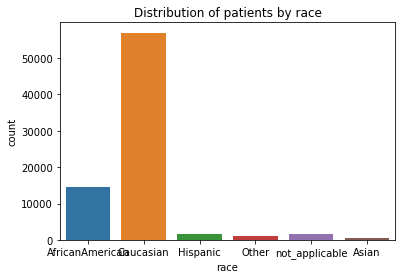

readmitted  race           
0           Caucasian          66.222944
            AfricanAmerican    16.843981
            not_applicable      2.055710
            Hispanic            1.777947
            Other               1.371783
            Asian               0.567318
1           Caucasian           8.377444
            AfricanAmerican     2.178869
            Hispanic            0.210943
            not_applicable      0.182118
            Other               0.148053
            Asian               0.062890
Name: race, dtype: float64


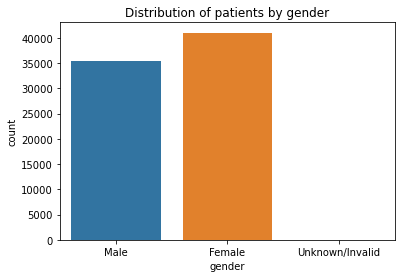

readmitted  gender         
0           Female             47.687490
            Male               41.148263
            Unknown/Invalid     0.003931
1           Female              6.041350
            Male                5.118967
Name: gender, dtype: float64


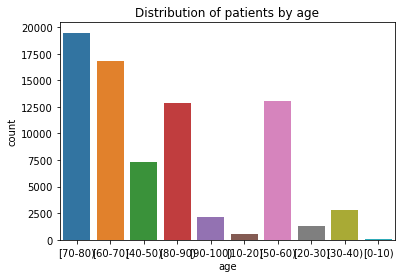

readmitted  age     
0           [70-80)     22.532886
            [60-70)     19.518107
            [50-60)     15.449924
            [80-90)     14.832818
            [40-50)      8.570043
            [30-40)      3.270269
            [90-100)     2.485457
            [20-30)      1.408469
            [10-20)      0.617106
            [0-10)       0.154604
1           [70-80)      2.980714
            [60-70)      2.456632
            [80-90)      2.029506
            [50-60)      1.656098
            [40-50)      1.035061
            [30-40)      0.425816
            [90-100)     0.302657
            [20-30)      0.231906
            [10-20)      0.039306
            [0-10)       0.002620
Name: age, dtype: float64


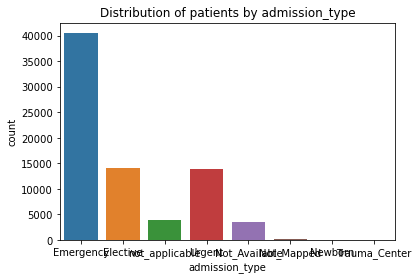

readmitted  admission_type
0           Emergency         46.986531
            Elective          16.617316
            Urgent            16.170536
            not_applicable     4.579163
            Not_Available      4.165138
            Not_Mapped         0.292175
            Trauma_Center      0.019653
            Newborn            0.009171
1           Emergency          6.151407
            Urgent             1.984959
            Elective           1.929930
            not_applicable     0.559457
            Not_Available      0.508359
            Not_Mapped         0.024894
            Newborn            0.001310
Name: admission_type, dtype: float64


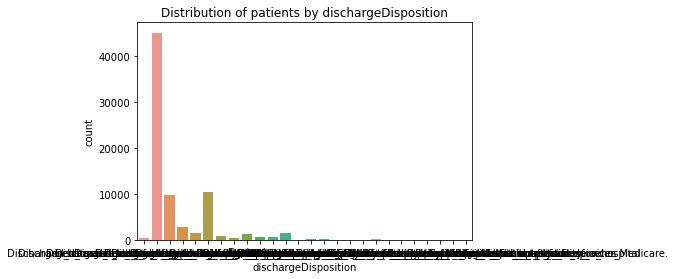

readmitted  dischargeDisposition                                                                                     
0           Discharged_to_home                                                                                           53.706567
            Discharged_transferred_to_SNF                                                                                11.723704
            Discharged_transferred_to_home_with_home_health_service                                                      11.139353
            not_applicable                                                                                                3.160212
            Discharged_transferred_to_another_short_term_hospital                                                         1.712436
            Expired                                                                                                       1.568314
            Discharged_transferred_to_another_rehab_fac_including_rehab_units_of_a_hospital_.   

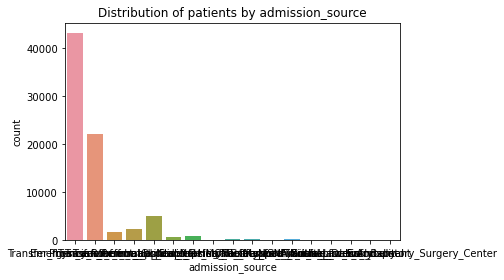

readmitted  admission_source                                         
0           Emergency_Room                                               50.011792
            Physician_Referral                                           25.909281
            not_applicable                                                5.889366
            Transfer_from_a_hospital                                      2.798595
            Transfer_from_another_health_care_facility                    2.039987
            Clinic_Referral                                               0.983963
            Transfer_from_a_Skilled_Nursing_Facility_(SNF)                0.742886
            HMO_Referral                                                  0.161155
            Not_Mapped                                                    0.140192
            Not_Available                                                 0.120539
            Court_Law_Enforcement                                         0.013102
            Trans

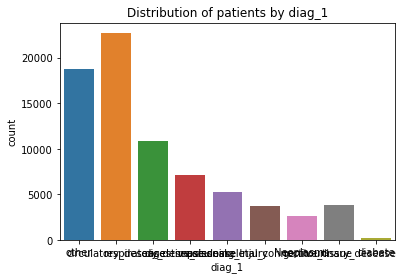

readmitted  diag_1                           
0           circulatory_desease                  26.378334
            other                                21.703527
            respiratory_desease                  12.830826
            digestive_desease                     8.304072
            poisoning_Injury                      6.038730
            genitourinary_desease                 4.469105
            musculoskeletal_connective_tissue     4.410146
            Neoplasms                             3.127457
            diabete                               0.222735
1           circulatory_desease                   3.396048
            other                                 2.870657
            respiratory_desease                   1.377024
            digestive_desease                     1.003616
            poisoning_Injury                      0.866045
            genitourinary_desease                 0.550286
            musculoskeletal_connective_tissue     0.457261
          

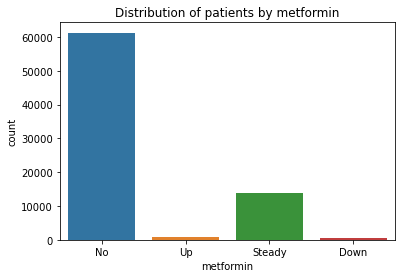

readmitted  metformin
0           No           71.031392
            Steady       16.323830
            Up            0.997065
            Down          0.487396
1           No            9.212043
            Steady        1.788428
            Up            0.093024
            Down          0.066820
Name: metformin, dtype: float64


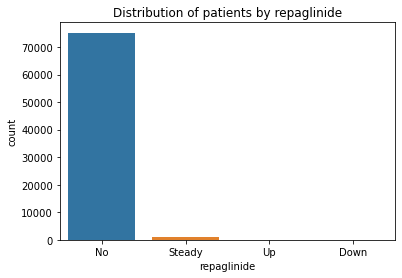

readmitted  repaglinide
0           No             87.525549
            Steady          1.172632
            Up              0.095645
            Down            0.045857
1           No             10.965096
            Steady          0.175567
            Up              0.017033
            Down            0.002620
Name: repaglinide, dtype: float64


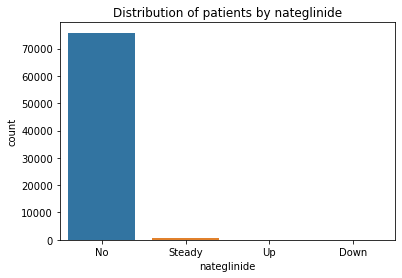

readmitted  nateglinide
0           No             88.233059
            Steady          0.575179
            Up              0.019653
            Down            0.011792
1           No             11.088255
            Steady          0.072061
Name: nateglinide, dtype: float64


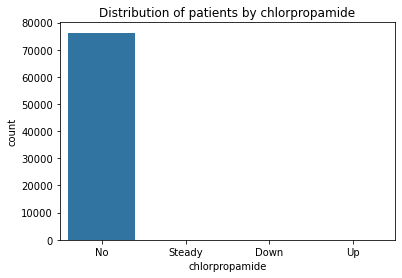

readmitted  chlorpropamide
0           No                88.758451
            Steady             0.074682
            Up                 0.005241
            Down               0.001310
1           No                11.155076
            Steady             0.005241
Name: chlorpropamide, dtype: float64


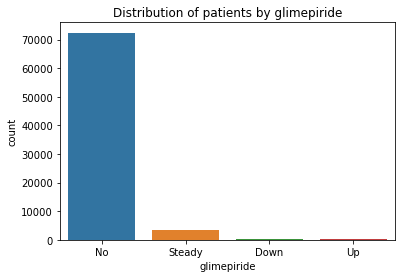

readmitted  glimepiride
0           No             84.229076
            Steady          4.166448
            Up              0.281694
            Down            0.162465
1           No             10.640166
            Steady          0.457261
            Up              0.035376
            Down            0.027514
Name: glimepiride, dtype: float64


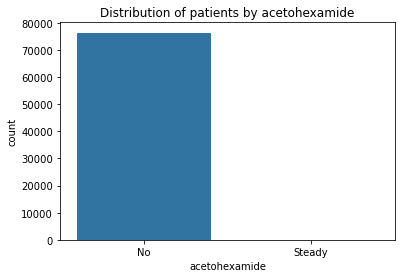

readmitted  acetohexamide
0           No               88.838373
            Steady            0.001310
1           No               11.160317
Name: acetohexamide, dtype: float64


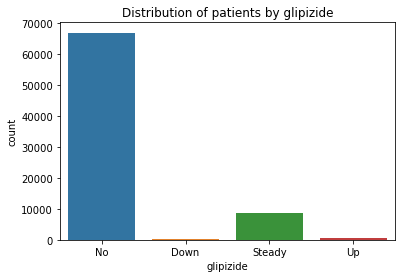

readmitted  glipizide
0           No           77.828730
            Steady        9.919553
            Up            0.643310
            Down          0.448090
1           No            9.747917
            Steady        1.226351
            Up            0.103506
            Down          0.082543
Name: glipizide, dtype: float64


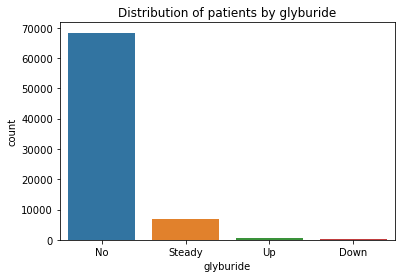

readmitted  glyburide
0           No           79.526754
            Steady        8.089199
            Up            0.724543
            Down          0.499188
1           No           10.040092
            Steady        0.976102
            Up            0.083853
            Down          0.060269
Name: glyburide, dtype: float64


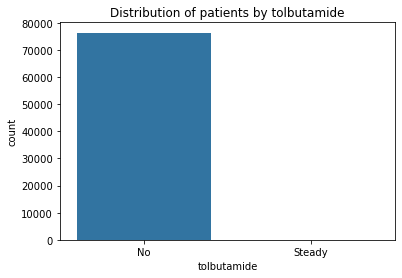

readmitted  tolbutamide
0           No             88.820030
            Steady          0.019653
1           No             11.160317
Name: tolbutamide, dtype: float64


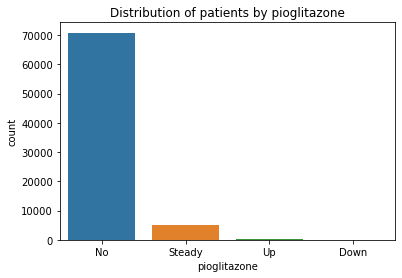

readmitted  pioglitazone
0           No              82.407893
            Steady           6.131754
            Up               0.199151
            Down             0.100886
1           No              10.410880
            Steady           0.706200
            Up               0.026204
            Down             0.017033
Name: pioglitazone, dtype: float64


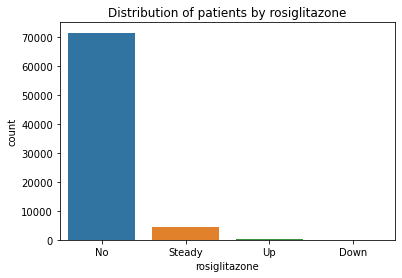

readmitted  rosiglitazone
0           No               83.195325
            Steady            5.408522
            Up                0.155914
            Down              0.079922
1           No               10.531419
            Steady            0.609245
            Up                0.018343
            Down              0.001310
Name: rosiglitazone, dtype: float64


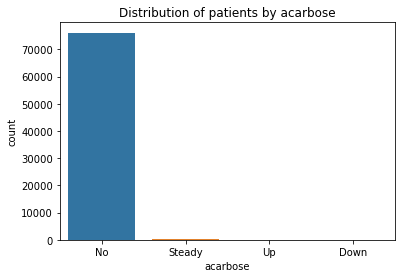

readmitted  acarbose
0           No          88.565851
            Steady       0.263351
            Up           0.007861
            Down         0.002620
1           No          11.135423
            Steady       0.022273
            Down         0.001310
            Up           0.001310
Name: acarbose, dtype: float64


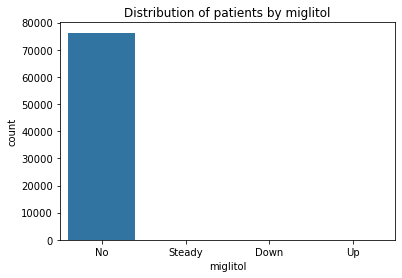

readmitted  miglitol
0           No          88.802998
            Steady       0.031445
            Down         0.003931
            Up           0.001310
1           No          11.156386
            Steady       0.002620
            Down         0.001310
Name: miglitol, dtype: float64


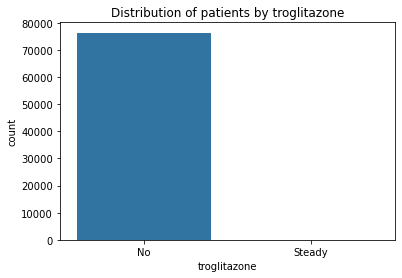

readmitted  troglitazone
0           No              88.837063
            Steady           0.002620
1           No              11.160317
Name: troglitazone, dtype: float64


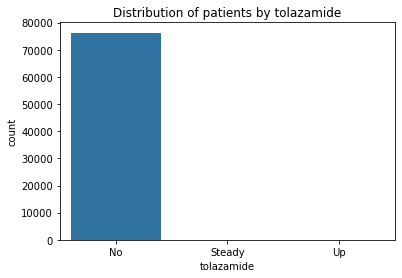

readmitted  tolazamide
0           No            88.804308
            Steady         0.034065
            Up             0.001310
1           No            11.157696
            Steady         0.002620
Name: tolazamide, dtype: float64


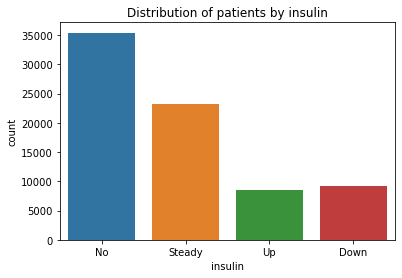

readmitted  insulin
0           No         41.722132
            Steady     26.932551
            Down       10.392537
            Up          9.792464
1           No          4.651224
            Steady      3.402599
            Down        1.686232
            Up          1.420261
Name: insulin, dtype: float64


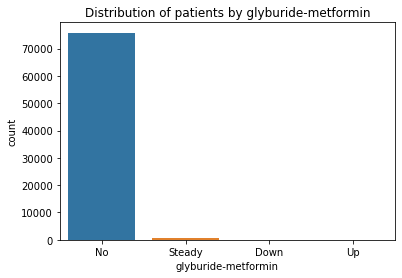

readmitted  glyburide-metformin
0           No                     88.225198
            Steady                  0.598763
            Up                      0.010482
            Down                    0.005241
1           No                     11.081704
            Steady                  0.078612
Name: glyburide-metformin, dtype: float64


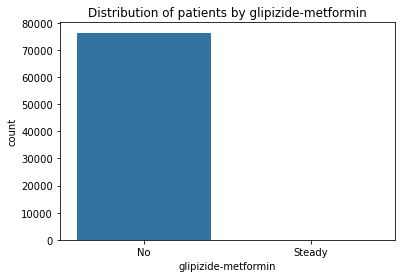

readmitted  glipizide-metformin
0           No                     88.826581
            Steady                  0.013102
1           No                     11.159006
            Steady                  0.001310
Name: glipizide-metformin, dtype: float64


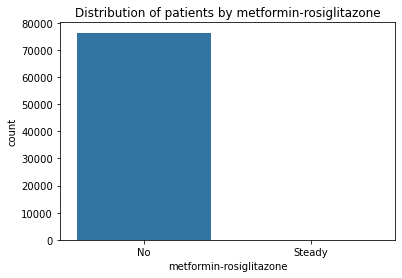

readmitted  metformin-rosiglitazone
0           No                         88.837063
            Steady                      0.002620
1           No                         11.160317
Name: metformin-rosiglitazone, dtype: float64


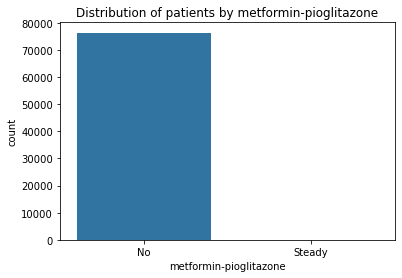

readmitted  metformin-pioglitazone
0           No                        88.838373
            Steady                     0.001310
1           No                        11.160317
Name: metformin-pioglitazone, dtype: float64


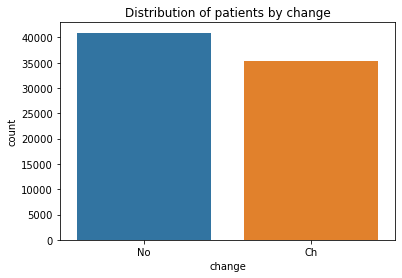

readmitted  change
0           No        47.939049
            Ch        40.900634
1           No         5.702007
            Ch         5.458309
Name: change, dtype: float64


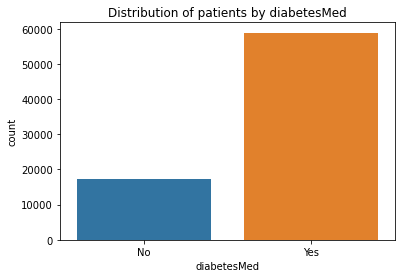

readmitted  diabetesMed
0           Yes            68.197422
            No             20.642262
1           Yes             8.982758
            No              2.177559
Name: diabetesMed, dtype: float64


In [176]:
for col in df_object_temporary.columns:
    sns.countplot(x=col,data=train_data)
    plt.title(f"Distribution of patients by {col}")
    plt.show()
    #let's see percenatage of labels who didn't subscribe to term deposit,
    #and percenatage of customers who subscribed to term deposit
    print(train_data.groupby('readmitted')[col].value_counts()/len(train_data)*100)

- Choose a threshold
- Sort unique values in the column by their frequency in descending order
- Keep adding the frequency of these sorted (descending) unique values until a threshold is reached.
- These are the unique categories we will keep and instances of all other categories shall be replaced by “other”.

In [177]:
from collections import Counter
def cumulatively_categorise(column,threshold=0.9,return_categories_list=False):
  #Find the threshold value using the percentage and number of instances in the column
  threshold_value=int(threshold*len(column))
  #Initialise an empty list for our new minimised categories
  categories_list=[]
  #Initialise a variable to calculate the sum of frequencies
  s=0
  #Create a counter dictionary of the form unique_value: frequency
  counts=Counter(column)

  #Loop through the category name and its corresponding frequency after sorting the categories by descending order of frequency
  for i,j in counts.most_common():
    #Add the frequency to the global sum
    s+=dict(counts)[i]
    #Append the category name to the list
    categories_list.append(i)
    #Check if the global sum has reached the threshold value, if so break the loop
    if s>=threshold_value:
        break
  #Append the category Other to the list
  categories_list.append('Other')

  #Replace all instances not in our new categories by Other  
  new_column=column.apply(lambda x: x if x in categories_list else 'Other')

  #Return transformed column and unique values if return_categories=True
  if(return_categories_list):
        return new_column
  #Return only the transformed column if return_categories=False
  else:
        return new_column

In [178]:
train_data.columns[train_data.isna().any()]
# remember we still have null values in this column

Index(['diag_1'], dtype='object')

In [179]:
# I don't want to apply this function to the column diag_1 as we have null values there
del df_object_temporary['diag_1']
cols = df_object_temporary.columns
train_data[cols] = df_object_temporary.apply(cumulatively_categorise)

In [180]:
test_data.set_index('readmitted')['diag_1'].isna().sum(level=0)

readmitted
0    361
1     67
Name: diag_1, dtype: int64

In [181]:
for i in train_data[cols]:
    print("*"*100)
    print("Columns {}".format(i))
    print(train_data[i].value_counts())
    print('\n')

****************************************************************************************************
Columns race
Caucasian          56938
AfricanAmerican    14519
Other               4867
Name: race, dtype: int64


****************************************************************************************************
Columns gender
Female    41008
Male      35313
Other         3
Name: gender, dtype: int64


****************************************************************************************************
Columns age
[70-80)    19473
[60-70)    16772
[50-60)    13056
[80-90)    12870
[40-50)     7331
Other       6822
Name: age, dtype: int64


****************************************************************************************************
Columns admission_type
Emergency         40557
Elective          14156
Urgent            13857
not_applicable     3922
Other              3832
Name: admission_type, dtype: int64


*********************************************************************

I will also delete those columns where we have dominant levels  see the examples like tolbutamide  where only 15 values are other, we will not have need this type of values, because classification might make decision based on such features.

In [182]:
#gender 3 other

In [183]:
high_cardinality = ['metformin-pioglitazone','metformin-rosiglitazone','glipizide-metformin','tolazamide',
'troglitazone', 'miglitol', 'tolbutamide', 'chlorpropamide', 'acetohexamide']

train_data.drop(columns=high_cardinality, inplace=True)
test_data.drop(columns=high_cardinality, inplace=True)

In [184]:
train_data['gender'].unique()

array(['Male', 'Female', 'Other'], dtype=object)

In [185]:
train_data = train_data[train_data.gender != 'Other']
train_data.reset_index(inplace=True,drop=True)

In [186]:
columns_need_to_be_processed = list(set(cols)-set(high_cardinality))
for_test_data_mapping = dict(train_data[columns_need_to_be_processed].apply(lambda x:x.unique()))

In [187]:
for_test_data_mapping

{'nateglinide': array(['No', 'Other'], dtype=object),
 'acarbose': array(['No', 'Other'], dtype=object),
 'rosiglitazone': array(['No', 'Other'], dtype=object),
 'glyburide': array(['No', 'Steady', 'Other'], dtype=object),
 'diabetesMed': array(['No', 'Yes'], dtype=object),
 'metformin': array(['No', 'Other', 'Steady'], dtype=object),
 'insulin': array(['No', 'Steady', 'Up', 'Down'], dtype=object),
 'admission_type': array(['Emergency', 'Elective', 'not_applicable', 'Urgent', 'Other'],
       dtype=object),
 'glipizide': array(['No', 'Other', 'Steady'], dtype=object),
 'pioglitazone': array(['No', 'Other'], dtype=object),
 'dischargeDisposition': array(['Other', 'Discharged_to_home',
        'Discharged_transferred_to_home_with_home_health_service',
        'not_applicable',
        'Discharged_transferred_to_another_short_term_hospital',
        'Discharged_transferred_to_SNF'], dtype=object),
 'race': array(['AfricanAmerican', 'Caucasian', 'Other'], dtype=object),
 'gender': array(['

In [188]:
for key in for_test_data_mapping:
    for i in range(0, len(test_data)):
        if test_data.loc[i,key] not in for_test_data_mapping[key]:
            test_data.loc[i,key] = "Other"
        

Handling Missing values in diag_1

In [189]:
for_knn_training = train_data[~train_data['diag_1'].isna()].drop('readmitted',1)

In [190]:
from sklearn.neighbors import KNeighborsClassifier
knn_num_data=for_knn_training.select_dtypes(exclude="object")## we divide data in this groups to check variance, 
knn_object=for_knn_training.select_dtypes(include="object")#
knn_object.drop(columns=["diag_1"],inplace=True)
knn_dummies=pd.get_dummies(knn_object,columns=knn_object.columns,drop_first=True)
x_train_knn = knn_dummies.join(knn_num_data)

for_knn_test = test_data[test_data['diag_1'].isna()].drop('readmitted',1)
knn_num_data_test=for_knn_test.select_dtypes(exclude="object")## we divide data in this groups to check variance, 
knn_object_test=for_knn_test.select_dtypes(include="object")#
knn_object_test.drop(columns=["diag_1"],inplace=True)
knn_dummies_test=pd.get_dummies(knn_object_test,columns=knn_object_test.columns,drop_first=True)
x_test =  knn_dummies_test.join(knn_num_data_test)


x_test = x_test[x_test.columns.intersection(x_train_knn.columns)]
x_train_knn = x_train_knn[x_train_knn.columns.intersection(x_test.columns)]

y_train_knn = for_knn_training['diag_1']
knn = KNeighborsClassifier(n_neighbors=5, metric='minkowski',p=2).fit(x_train_knn,y_train_knn)

In [191]:
def fill_na(data):
    knn_num_data_test=data.drop('readmitted',1).select_dtypes(exclude="object")## we divide data in this groups to check variance, 
    knn_object_test=data.drop('readmitted',1).select_dtypes(include="object")#
    knn_object_test.drop(columns=["diag_1"],inplace=True)
    knn_dummies_test=pd.get_dummies(knn_object_test,columns=knn_object_test.columns,drop_first=True)
    x_test =  knn_dummies_test.join(knn_num_data_test)
    x_test = x_test[x_test.columns.intersection(x_train_knn.columns)]
    return knn.predict(x_test)

In [192]:
predicted = fill_na(train_data[train_data['diag_1'].isna()])
train_data.loc[train_data['diag_1'].isna(),'diag_1'] = predicted
predicted_test = fill_na(test_data[test_data['diag_1'].isna()])
test_data.loc[test_data['diag_1'].isna(),'diag_1'] = predicted_test

In [193]:
train_data['diag_1'].isna().any()

False

In [195]:
test_data['diag_1'].isna().any()

False

In [202]:
train_data.to_csv("cleaned_train.csv",index=False)

In [203]:
test_data.to_csv("cleaned_test.csv",index=False)